In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# def variable
from torch.autograd import Variable

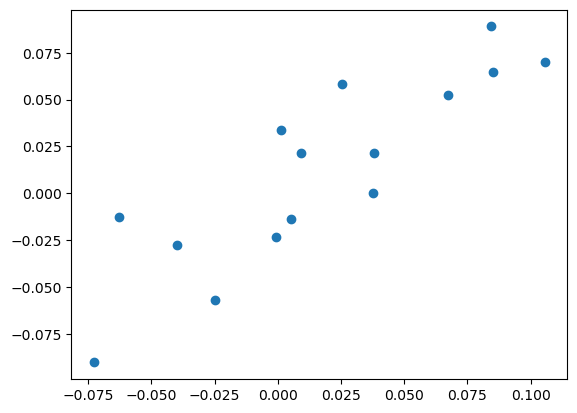

In [2]:
from src.models import LVGEBM
model = LVGEBM(15,4,10000)
y = model(model.z)
# plot y
y = y.detach().numpy()
plt.scatter(y[:,0],y[:,1])

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


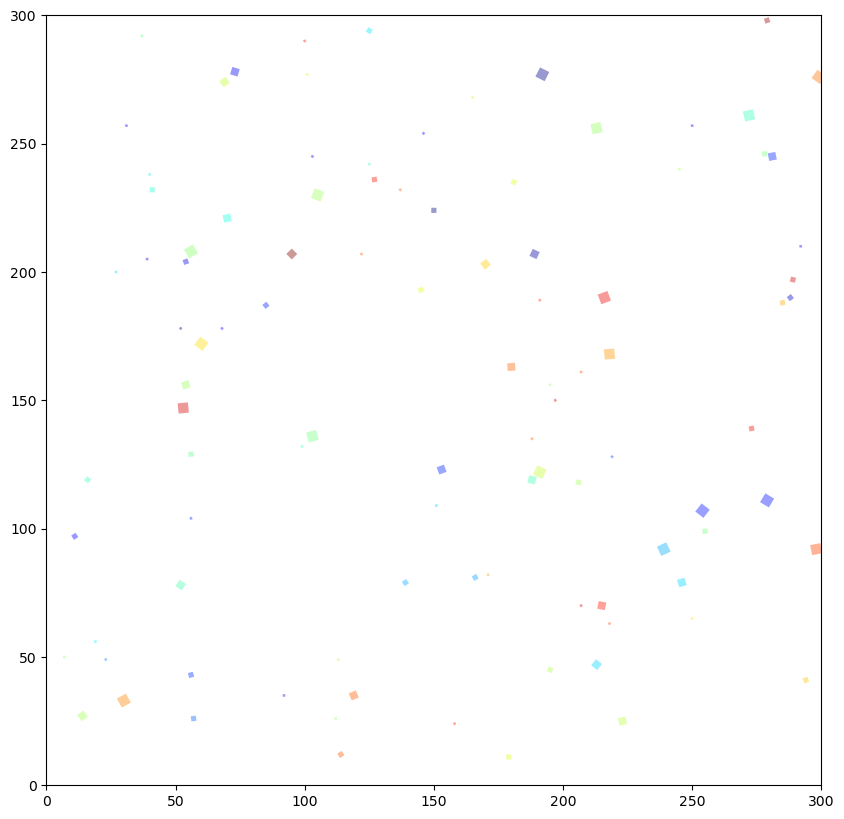

In [4]:
from src.utils.data import loadData

# load data
sq, qp = loadData(100)
print(sq[0])
from src import visualization as vis
vis.plot_data(sq,limits=[0,300,0,300])

## Linf

In [5]:
from src.metrics import Linf
from src.ebmUtils import Reg, RegLatent, loss_functional

In [6]:
n_centroids = 4
output_dim = 2
latent_size = 400
model = LVGEBM(n_centroids, output_dim, latent_size=latent_size)

# criterion
criterion = Linf
# optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
c2 = nn.MSELoss()
# epochs
epochs = 200
times = 10
p_times = epochs / times
# create times * figures
col = 4
row = int(times / col) + 1
#fig, axs = plt.subplots(row, col, figsize=(10, 10))
# y = torch.tensor(spiral_data, dtype=torch.float32)
y = sq
# input =torch.from_numpy(spiral_data).float()
input = sq
costs = []
best_model = None
best_cost = float('inf')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
costs = []
rem = []
reg = []
rem.append(torch.tensor(1))
p_c = []
p_p = []
reg_let_r = []
reg_cost_r = []
models = []
test = False
for epoch in range(epochs):

    # forward
    outputs = model(model.z)
    # add random noise
    if epoch %2 == 0:
        outputs = outputs + torch.randn_like(outputs)*(rem[-1].item()/100)
    # calculate cost
    reg_cost = Reg(outputs)
    reg_cost_r.append(reg_cost)
    reg_let = 0
    if epoch > 1:
        reg_let = RegLatent(model.z_l)
        reg_let_r.append(reg_let)
    """
    y_n = ency(y)
    c2_cost = loss_functional(outputs, y_n.detach().numpy(), model)
    c2_cost.requires_grad = True
    c2_cost = c2_cost.min(1)[0]
    c2_cost = torch.sum(c2_cost)
    y_r = decy(y_n)
    c3_cost = c2(sq, y_r)
    """
    outputs = outputs.detach().numpy()
    # make outputs numpy
    #cost = loss_functional(outputs, y.detach().numpy(), model)
    cost = loss_functional(outputs, y, model)
    cost.requires_grad = True
    c1 = cost
    F, z = cost.min(1)
    rem.append(torch.sum(F))
    cost = torch.sum(F) + 10*reg_cost + 10*reg_let 
    #cost = torch.sum(F) +5*reg_cost + 10*reg_let
    #cost = torch.sum(F) + reg_cost + reg_let
    if test == True:
        cost = c2_cost + reg_cost + reg_let + c3_cost
    reg.append(reg_cost)
    # backward
    optimizer.zero_grad()
    # make sure cost is torch tensor
    costs.append(cost.item())
    #rem.append(cost)
    cost.backward()
    optimizer.step()
    if cost < best_cost:
        best_cost = cost
        best_model = model
        best_outputs = outputs
        best_z = z
        best_lat = model.z_l
        best_epoch = epoch
    if cost < 4100:
        p_p.append(outputs)
        p_c.append(cost)
    # print
    if (epoch + 1) % p_times == 0:
        # print
        print('Epoch [{}/{}], Cost: {:.4f}'.format(epoch + 1, epochs, cost.item()))
        # plot outputs point
        #axs.flat[int(epoch / p_times)].scatter(outputs[:, 0], outputs[:, 1])
        # put title
        #axs.flat[int(epoch / p_times)].set_title('Epoch [{}/{}], Cost: {:.4f}'.format(epoch + 1, epochs, cost.item()),
        #                                         fontsize=5)    


Epoch [20/200], Cost: 8297.5303
Epoch [40/200], Cost: 7770.2456
Epoch [60/200], Cost: 8242.2803
Epoch [80/200], Cost: 8622.1074
Epoch [100/200], Cost: 7923.3662
Epoch [120/200], Cost: 7842.5542
Epoch [140/200], Cost: 9057.2559
Epoch [160/200], Cost: 8143.3213
Epoch [180/200], Cost: 7615.8325
Epoch [200/200], Cost: 8072.1079


torch.Size([200])
torch.Size([97]) torch.Size([103])


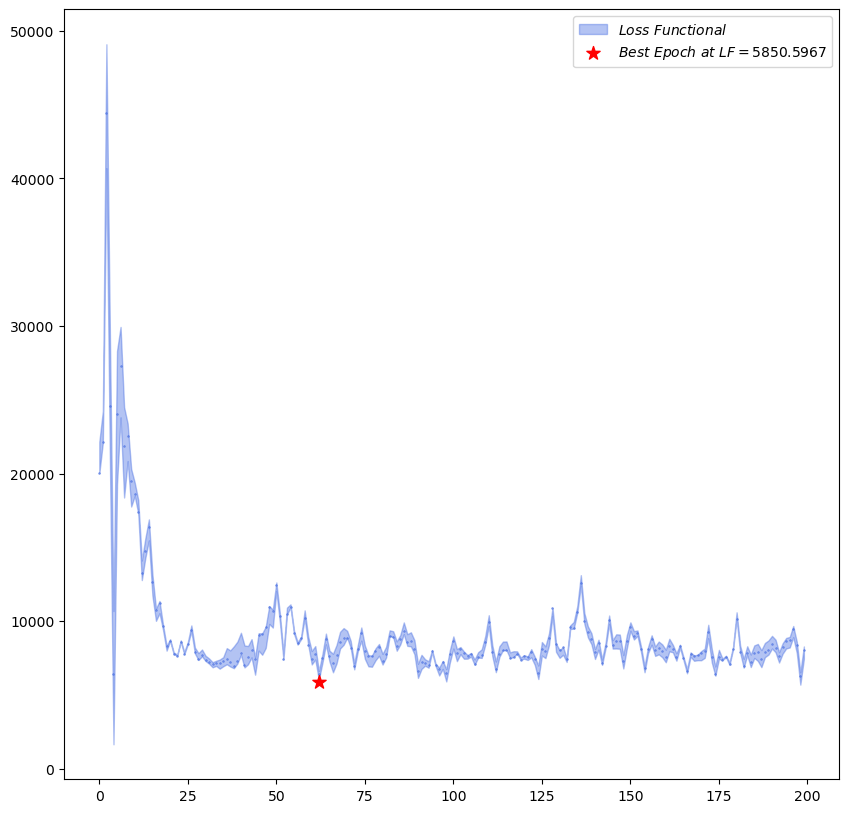

In [11]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt
sam = epochs
def extract_envelopes(signal, cutoff_frequency):
    # Apply a low-pass filter to remove high-frequency noise
    b, a = butter(4, cutoff_frequency / (0.5 * len(signal)), btype='lowpass')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

signal = costs[:sam]
signal = torch.tensor(signal)
# Extract the upper and lower envelopes of the signal
upper_envelope = extract_envelopes(signal, cutoff_frequency=0.4*sam)
a1 = torch.tensor(upper_envelope-signal.numpy())
# take only >0
print(a1.shape)
a1_p = a1[a1>0]
a1_n = a1[a1<0]
print(a1_p.shape, a1_n.shape)
# double the size of a1_p
a1_pd = []
for i in range(a1_p.shape[0]):
    a1_pd.append(a1_p[i])
    a1_pd.append(a1_p[i])
# make it to 1000 shape
a1_pd_v = sam - len(a1_pd)
if a1_pd_v > 0:
    for i in range(a1_pd_v):
        a1_pd.append(a1_pd[-1])
elif a1_pd_v < 0:
    for i in range(-a1_pd_v):
        a1_pd.pop()
a1_nd = []
for i in range(a1_n.shape[0]):
    a1_nd.append(a1_n[i])
    a1_nd.append(a1_n[i])
a1_nd_val = sam - len(a1_nd)
if a1_nd_val > 0:
    for i in range(a1_nd_val):
        a1_nd.append(a1_nd[-1])
elif a1_nd_val < 0:
    for i in range(-a1_nd_val):
        a1_nd.pop()
a1_pd_ = a1_pd + upper_envelope
a1_nd_ = a1_nd + upper_envelope
# Plot the original signal and its envelopes
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(signal, label='Signal')
ax.scatter(range(sam), upper_envelope, s=1, c='royalblue', alpha=0.5, marker='*')
# pass a1_nd_ through a low pass filter
a1_nd_ = torch.tensor(a1_nd_)
#ax.plot(a1_nd_, label='a1_nd')

# make a paint area between a1_pd_ and a1_nd_ of color red
colour = 'royalblue'
label2 = '$Loss\ Functional$'
ax.fill_between(range(sam), a1_nd_, a1_pd_, color=colour, alpha=0.4, label = label2)
# plot best_epoch
if sam>best_epoch:
    label2 = '$Best\ Epoch\ at\ LF={:.4f}$'.format(costs[best_epoch])
    ax.scatter(best_epoch, signal[best_epoch], s=100, c='r', marker='*', label=label2)
# name axis
# plot signal
#ax.plot(signal, label='Signal')
# make axis bigger
# plot costs
#ax.scatter(range(sam), signal, s=10, c='r', alpha=0.5, marker='*')
# plot line of costs
#ax.plot(range(sam), signal, c='r', alpha=0.5, label='$Costs$')
ax.legend()
plt.show()

In [ ]:
#print
print("Best loss: {:.4f}".format(best_cost.item()))

In [ ]:
model = best_model
# plot manifold
x_discr = 100
y_discr = 100
manifold = torch.zeros(x_discr, y_discr, 4)
x_lim = [0,300]
y_lim = [0,300]
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], x_discr)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], y_discr)):
        manifold[i, j, :] = torch.Tensor([x, y, 0,0])

print(manifold.shape)
# break manifold to batches of nx2
manifold = manifold.view(-1, 4) # 10000x3 take -> 10000x2 (drop 3rd dim)
points = manifold[:, :2]
# add 2 more columns to points and make them 0
points = torch.cat((points, torch.zeros(points.shape[0], 2)), 1)
print(points.shape)# run through the network
#outputs = p_p[-2]
outputs = best_outputs
print("outputs.shape", outputs.shape)
c1 = loss_functional
#cost = criterion(outputs, points) # 400x2 cdot 15x2
points = points.detach().numpy()
cost = c1(outputs, points,model) # 400x2 cdot 15x2
print("cost.shape", cost.shape)
F, z = cost.min(1) # F is the min distance, z is the index of the min distance
print("F.shape", F.shape)
for i in range(manifold.shape[0]):
    manifold[i,-2] = F[i]
    manifold[i,-1] = z[i]
# reshape to 100x100x3
manifold = manifold.reshape(100,100,4)

In [ ]:

manifold_plot = manifold.detach().numpy()
# plot manifold as contour
fig = plt.figure(figsize=(10,10))

#make 3d plot
ax = fig.add_subplot(111)
# plot class
level = 200
ax.contourf(manifold_plot[:,:,0], manifold_plot[:,:,1], manifold_plot[:,:,-2], levels=level, cmap='viridis', alpha=0.9)
# plot scatter of output = model(model.z)
o = best_outputs
# lb is 0,..,no
no = n_centroids
lb = np.linspace(0, no-1, no)
ax.scatter(o[:,0], o[:,1],c=lb, s=50)
ax.set_xlim([0,300])
ax.set_ylim([0,300])
# also vis data
plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])
m1 = manifold_plot 

In [ ]:
def loss_functional(y_hat, y_target, model):
    n_centroids = y_hat.shape[0]
    n_data = y_target.shape[0]
    size = (n_data, n_centroids)
    loss = torch.zeros(size)
    for i in range(n_data):
        for j in range(n_centroids):
            # get square
            square = geo.create_square2(y_target[i])
            #square = torch.tensor(square)
            #y_hat[j] = y_hat[j].clone().detach().requires_grad_(True)
            loss[i, j], _, _ = Linf(square, y_hat[j])
    return loss 
#

In [ ]:
# plot p_p

# get viridis colors for each epoch
from matplotlib import cm
# n colors not virids
colors = cm.cool(np.linspace(0, 1, p_p.__len__())) # 0 -> 6 colors

#colors = cm.viridis(np.linspace(0, 1, p_p.__len__())) # 0 -> 6 colors
print(colors.__len__())
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(p_p)):
    o = p_p[i]
    ax.scatter(o[:,0], o[:,1], s=400, alpha=0.5)
    #ax.plot(o[:,0], o[:,1],c=color[i], alpha=0.5, linestyle='dashed',label='Epoch {}'.format(i))
    ax.set_xlim([0,300])
    ax.set_ylim([0,300])
    # also vis data
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=p_p.__len__()))
sm.set_array([])
# name colorbar
cbar =  plt.colorbar(sm, ticks=np.linspace(0,p_p.__len__(),p_p.__len__()+1))
cbar.set_label('$Possible\ Solutions$', rotation=0, labelpad=40)

plt.show()
# plot p_p

In [ ]:
# make points in p_p in one array
fuzzy_array = np.zeros((p_p.__len__()*p_p[0].shape[0], p_p[0].shape[1]))
for i in range(p_p.__len__()):
    for j in range(p_p[0].shape[0]):
        fuzzy_array[i*p_p[0].shape[0]+j] = p_p[i][j]

# plot fuzzy_array
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(fuzzy_array[:,0], fuzzy_array[:,1], s=100, c='royalblue', alpha=0.5)
ax.set_xlim([0,300])
ax.set_ylim([0,300])
# also vis data

In [ ]:
# plot best_centroids
best_centroids = best_outputs
best_centroids = torch.tensor(best_centroids)
best_centroids = best_centroids.detach().numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(best_centroids[:,0], best_centroids[:,1], c='r', s=50)
# also vis data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geometry as geo
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def plot_data(fig,ax ,data, size=10, limits=[-10, 10, -10, 10]):
    """
        Plot the data points 

        Parameters:
            data: data to be plotted
            size: size of the plot
            limits: limits of the plot

        Returns:
            None
    """
    patches = []
    num_polygons = data.__len__()

    for i in range(num_polygons):
        square = geo.create_square2(data[i])
        # print(square.shape)
        polygon = Polygon(square, True)
        patches.append(polygon)

    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax.add_collection(p)
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])


## VOr

In [ ]:
class Voronoi(nn.Module):
    def __init__(self, n_centroids, input_dim, output_dim):
        super(Voronoi, self).__init__()
        self.n_centroids = n_centroids
        self.input_dim = input_dim
        self.output_dim = output_dim
        # inputs are datapoints and outputs are energies
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n_centroids)

        )

    def forward(self, x):
        x = self.predictor(x)
        return x
        
vor = Voronoi(10, 2, 2)
x = qp[0:3]
print(x.shape)
x = torch.tensor(x, dtype=torch.float32)
y = vor(x)
print(y.shape)

In [ ]:
torchsummary.summary(best_model)

In [ ]:
best_model.parameters.__sizeof__()

In [ ]:
vor.parameters().__sizeof__()

In [ ]:
qp = np.load('100qp.npy')
# permute qp
qp = np.random.permutation(qp)
qp = qp[:200]
qp = torch.tensor(qp)
def getE(model, best_outputs, qp):
    # get qp
    qp = torch.tensor(qp)
    # get outputs
    outputs = best_outputs
    outputs = torch.tensor(outputs)
    # make Linf between outputs points and qp (between them all)
    E = torch.zeros(outputs.shape[0], qp.shape[0])
    for i in range(outputs.shape[0]):
        for j in range(qp.shape[0]):
            E[i,j] = torch.max(torch.abs(outputs[i] - qp[j]))
    F, z = E.min(0)
    # now do the same for sq
    outputs = outputs.detach().numpy()
    sq_ = np.load('100sq.npy')
    E_sq = loss_functional(outputs, sq_, model)
    F_sq, z_sq = E_sq.min(1)
    
    return F, z, F_sq, z_sq

def NearestNeighbour(qp, sq):
    d_nn = np.inf
    z_nn = 0
    for i, square in enumerate(sq):
        d_nn_sq,_,_ = Linf(square, qp)
        if d_nn_sq <= d_nn:
            d_nn = d_nn_sq
            z_nn = i
    return d_nn, z_nn

def Accuracy(F, z, F_sq, z_sq, qp, sq):
    acc = 0
    for i in range(qp.shape[0]):
        # find nn of qp[i]
        d_nn, z_nn = NearestNeighbour(qp[i], sq)
        
        #print("d_nn: ", d_nn)
        #print("z_nn: ", z_nn)
        #print("z[i]: ", z[i])
        #print("z_sq[z_nn]: ", z_sq[z_nn])
        if z_sq[z_nn] == z[i]:
            acc += 1
    return acc/qp.shape[0]

F, z, F_sq, z_sq = getE(best_model,best_outputs, qp)


In [ ]:
#plot qp
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#labels are z
labels = z.cpu()
plt_qp = qp.cpu().detach().numpy()
ax.scatter(plt_qp[:,0], plt_qp[:,1], c=labels, s=50)
# plot best_outputs
plt_bo = best_outputs
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:,0], plt_bo[:,1], c=c, s=200)
z_labels = z
plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

In [ ]:
F_ps[0]

In [ ]:
z_ps[0]

In [ ]:
qq

## DIST

In [ ]:
qs = pseudo_clusters[2][1]
Linf(qs, qq)

In [ ]:
print(NearestNeighbour(qq, pseudo_clusters[2]))

In [ ]:
print(qq)
print(pseudo_clusters[0][3])
print(pseudo_clusters[1][8])
print(pseudo_clusters[2][1])
print(pseudo_clusters[3][1])

In [ ]:
NearestNeighbour(qq, pseudo_clusters[2])

In [ ]:
# print qq
plt.scatter(qq[0], qq[1], c='r', s=100)
# print squares 3 8 1 1 of pseudo_classes
ls = ['r', 'g', 'b', 'y']
for i in range(4):
    square = geo.create_square2(pseudo_clusters[i][int(z_ps[0][i].item())] )
    plt.plot(square[:,0], square[:,1], c=ls[i], alpha=0.5, linestyle='dashed')
    # make axis equal
    plt.axis('equal')
    # set lim
    #plt.xlim([100,210])
    #plt.ylim([0,300])


In [ ]:
vor = Voronoi(4, 2, 2).to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

loss = nn.L1Loss()
qp = torch.tensor(qp)
optimizer = torch.optim.Adam(vor.parameters(), lr=1e-3)
epochs = 10000
squares = np.load('100sq.npy')
pseudo_clusters = []
for i in range(n_centroids):
    # append squares that their z_sq is i
    pseudo_clusters.append(squares[z_sq==i])
F_l = []
z_l = []
cost_l = []
qp = torch.tensor(qp).to(device)
outputs = torch.zeros(qp.shape[0], n_centroids)
F_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
z_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
ce = nn.CrossEntropyLoss()
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))

for epoch in range(epochs):
    #qp = np.load('100qp.npy')
    # get 1000 random points from qp
    # shuffle data
    #qp = torch.tensor(qp)
    #qp = qp[torch.randperm(qp.shape[0])][:100]
    qp = torch.tensor(qp, dtype=torch.float32).to(device)
    # get outputs
    outputs = vor(qp)
    # get pseudo labels

    
    # pass outputs through a hard arg max
    F, z = outputs.min(1)
    F_ps_m, z_ps_m = F_ps.min(1)
    # send to device
    F_ps_m = F_ps_m.to(device)
    z_ps_m = z_ps_m.to(device)
    # clone to device
    #make values of z_ps_m to be round to nearest integer
    r_z = torch.round(z_ps_m)

    # get loss
    alpha = 100
    beta = 1000
    z = z.float()
    #bce_loss = nn.BCELoss()(z, z_ps_m)
    z_ = outputs
    # make z_ float
    z_ = z_.float()
    z_cost = ce(z_, z_ps_m)
    F_cost = loss(F, F_ps_m)
    # get z_cost where we only penalize the wrong z and not its distance
    #z_cost = penalty(z, r_z)
    #F_l.append(F_cost.item())
    z_l.append(z_cost)
    #cost = alpha*F_cost + beta*z_cost
    cost = 10*z_cost 
    cost_l.append(cost.item())
    # backward
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if epoch%2000 ==0:
        print("Epoch: ", epoch, "Cost: ", cost.item())
        # lets check acc
        acc = 0
        for i in range(qp.shape[0]):
            F_e, z_e = outputs[i].max(0)
            if z_e == z_ps_m[i]:
                acc += 1
        print("Acc: ", acc/qp.shape[0])

            


In [ ]:
e = 10
x1 = outputs[e]
x2 = torch.tensor([[1]]).to(device)
x3 = z_ps_m[e]
print(f'x1: {x1}')
print(f'label is: {x3}')
for i in range(4):
    nu = i
    x4 = torch.tensor(nu).to(device)
    print(ce(x1,x4))

In [ ]:
def penalty(z_hat,z_target):
    loss = 0
    for i in range(z_hat.shape[0]):
        if z_hat[i] != z_target[i]:
            loss += 1
    return loss

In [ ]:
#print F_l and z_l

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(F_l, label='F')
z_l_p  = []
for i in range(len(z_l)):
    z_l_p.append(z_l[i]*beta)
ax.plot(z_l_p, label='z')
c_l = []
for i in range(len(F_l)):
    c_l.append(F_l[i]+beta*z_l[i])
ax.plot(c_l, label='c')
ax.legend()
# set ylim
ax.set_ylim([0,200])
#ax.set_xlim([-1,epochs])
#ax.set_ylim([0,100])

In [ ]:
model = vor
# plot manifold
x_discr = 100
y_discr = 100
manifold = torch.zeros(x_discr, y_discr, 4)
x_lim = [0,300]
y_lim = [0,300]
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], x_discr)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], y_discr)):
        manifold[i, j, :] = torch.Tensor([x, y, 0,0])

print(manifold.shape)
# break manifold to batches of nx2
manifold = manifold.view(-1, 4) # 10000x3 take -> 10000x2 (drop 3rd dim)
points = manifold[:, :2]
# add 2 more columns to points and make them 0
#points = torch.cat((points, torch.zeros(points.shape[0], 2)), 1)
# send to device
points = points.to(device)
print(points.shape)# run through the network
#outputs = p_p[-2]
E = vor(points)
F, z = E.max(1)
print("outputs.shape", outputs.shape)
#cost = criterion(outputs, points) # 400x2 cdot 15x2
#points = points.detach().numpy()
for i in range(manifold.shape[0]):
    manifold[i,-2] = F[i]
    manifold[i,-1] = z[i]
# reshape to 100x100x3
manifold = manifold.reshape(100,100,4)

In [ ]:
n = 500
print('points[n]: ',points[n])
print('E[n]: ', E[n])


In [ ]:
# import summary
import torchsummary
torchsummary.summary(best_model)

In [ ]:
from matplotlib import cm
manifold_plot = manifold.detach().numpy()
# plot manifold as contour
fig = plt.figure(figsize=(10,10))

#make 3d plot
ax = fig.add_subplot(111)
# plot class
level = 200
ax.contourf(manifold_plot[:,:,0], manifold_plot[:,:,1], manifold_plot[:,:,-1], levels=level, cmap='viridis', alpha=0.6)
ax.contourf(manifold_plot[:,:,0], manifold_plot[:,:,1], m1[:,:,-1], levels=level, cmap='viridis', alpha=0.1)
# plot scatter of output = model(model.z)
o = best_outputs
# lb is 0,..,no
no = n_centroids
lb = np.linspace(0, no-1, no)
ax.scatter(o[:,0], o[:,1],c=lb, s=100)
# also plot qp
qp_p = qp.cpu().detach().numpy()
#labels = z.cpu().detach().numpy()
ax.scatter(qp_p[:,0], qp_p[:,1],c=labels, s=10)
# -1 is the noise
#no = n_centroids
#color = cm.coolwarm(np.linspace(0, 1, no))
#for i in range(no):
#    ax.scatter(qp_p[labels==i,0], qp_p[labels==i,1],c=color[i], s=10)
#ax.set_xlim([0,300])
#ax.set_ylim([0,300])
# also vis data
plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

In [ ]:
# show all z
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(z.cpu().detach().numpy(), F.cpu().detach().numpy(), s=50)